# Building Model LSTM
### By **Néstor Suat** in 2020

**Descripción:** Generando un modelo ML para la tarea de NER en tweets de accidentes para las etiquetas `loc` y `time` usando el estandar BIO.

**Input:**
* TSV con dataset etiquetado con BIO

**Output:**
* Model

**Tomado de**: https://www.depends-on-the-definition.com/guide-sequence-tagging-neural-networks-python/
***

### Importando librerías

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("ggplot")

from gensim.models.doc2vec import Doc2Vec
import spacy

import fasttext
import fasttext.util

### Source code

La clase `StenteceGetter` es una clase generica en muchos proyectos de NER, permite tomar el dataset y prepararlo en una lista python para trabajar por oraciones.

In [2]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            #s = self.grouped["Sentence: {}".format(self.n_sent)]
            s = self.grouped[self.n_sent]
            self.n_sent += 1
            return s
        except:
            return None

### Importando dataset anotado

El archivo `ner-crf-training-data.tsv` fue construido anteriormente transformando el formato de anotación de Standoff a BIO.

In [3]:
file = 'ner-crf-training-data.tsv'
dir_ = "../../../data/v1/NER/train/"
train = pd.read_csv(dir_+file, delimiter = "\t", quoting = 3, names=['Sentence #','Word','POS','Tag'])
#dataset[:50]

In [4]:
file = 'ner-crf-test-data.tsv'
dir_ = "../../../data/v1/NER/test/"
test = pd.read_csv(dir_+file, delimiter = "\t", quoting = 3, names=['Sentence #','Word','POS','Tag'])

In [5]:
train['Tag'].value_counts()

O         20242
I-loc      3768
B-loc      1462
B-time      131
I-time      112
Name: Tag, dtype: int64

In [6]:
test['Tag'].value_counts()

O         5038
I-loc      893
B-loc      369
B-time      33
I-time      33
Name: Tag, dtype: int64

#### **Preparando el dataset**

Se construye un corpus de todas las palabras presentes en los tweets, se agrega un token esepcial para rellenar llamado ENDPAD, finalmente se calcula el tamaño del corpus de palabras. Esto mismo se hace para las etiquetas, aunque en este caso es más fácil porque son 5: `b-loc`, `i-loc`, `b-time`, `i-time` y `o`.

In [7]:
#tags = list(set(data["Tag"].values))
tags = ['B-loc', 'I-loc', 'B-time', 'I-time', 'O']
n_tags = len(tags); n_tags

5

Se toman los datos y se construye el arreglo de las oraciones a trabajar

### Trainset

In [8]:
getter = SentenceGetter(train)
train_sentences = getter.sentences
#sentences

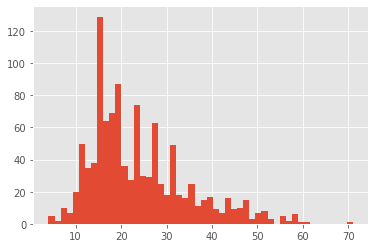

In [9]:
plt.hist([len(s) for s in train_sentences], bins=50)
plt.show()

En la gráfica anterior se puede observar el tamaño máximo de los tweets. Para Keras se necesita como entrada una longitud fija de secuencias, por esta razón se elije 70 como un valor máximo.

### Testset

In [10]:
getter = SentenceGetter(test)
test_sentences = getter.sentences

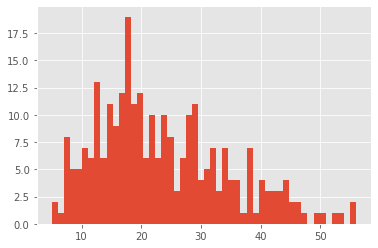

In [11]:
plt.hist([len(s) for s in test_sentences], bins=50)
plt.show()

In [12]:
max_len = 70
#word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

Finalmente se crea un dicccionario (key:value) del corpus de palabras y se le asigna un id.

In [13]:
tag2idx["B-time"] #Id para la etiqueta b-time

2

## Tokenize and prepare the sentences

Ahora se mapea las oraciones en una secuencia de números y si el tweet es más pequeño que el `max_len` se agrega una secuencia de pads.

In [14]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [23]:
#zeros = np.zeros(300,dtype=np.float32)
#X_train = [[word2idx[w[0]] for w in s] for s in train_sentences]
#X_train = pad_sequences(maxlen=max_len, dtype='float32', sequences=X_train, padding="post", value=zeros) # (1072,70,200)

y_train = [[tag2idx[w[2]] for w in s] for s in train_sentences]
y_train = pad_sequences(maxlen=max_len, sequences=y_train, padding="post", value=tag2idx["O"])

#print(X_train[1])
print(y_train[1])

[4 4 4 4 4 4 4 0 1 1 1 4 4 4 4 4 0 1 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]


In [24]:
#zeros = np.zeros(300,dtype=np.float32)
#X_test = [[word2idx[w[0]] if w[0] in words else word2idx['UNDEFINED'] for w in s] for s in test_sentences]
#X_test = pad_sequences(maxlen=max_len, dtype='float32', sequences=X_test, padding="post", value=zeros)

y_test = [[tag2idx[w[2]] for w in s] for s in test_sentences]
y_test = pad_sequences(maxlen=max_len, sequences=y_test, padding="post", value=tag2idx["O"])

#print(X_test[1])
print(y_test[1])

[4 4 4 4 4 2 3 3 4 4 4 4 4 4 0 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 0 1 1 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]


**Para entrenar la red, necesitamos tambien cambiar 'label' a categorical.**

In [25]:
y_train = [to_categorical(i, num_classes=n_tags) for i in y_train]
y_test = [to_categorical(i, num_classes=n_tags) for i in y_test]

## Train and Test set

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [17]:
_dir = "../../../data/v1/NER/numpy/"
X_train = np.load(_dir+'X_train-ft-300.npy')
X_test = np.load(_dir+'X_test-ft-300.npy')

In [18]:
print("Train:",X_train.shape, len(y_train))
print("Test:",X_test.shape, len(y_test))

Train: (1072, 70, 300) 1072
Test: (268, 70, 300) 268


## Build and fit the LSTM model

In [19]:
from tensorflow.keras.models import Model
from tensorflow.keras import Input, Sequential
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from tensorflow import keras
import tensorflow as tf


In [45]:
"""
from sklearn_crfsuite import metrics

acc = [] 
r_micro = []
r_macro = []
r_weighted = []
p_micro = []
p_macro = []
p_weighted = []
f1_micro = []
f1_macro = []
f1_weighted = []
loss_val = []
acc_val = []
for i in range(25):
    print(i)
    """
dropout = 0.5
input_shape=(70,300)

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, mode='min', restore_best_weights=True)


model = Sequential()
#model.add(Embedding(input_dim=n_words, output_dim=max_len, input_length=max_len)) # 70-dim embedding; input_dim=n_words+1 por el 9999 para otros tokens
model.add(Bidirectional(LSTM(units=100, return_sequences=True, dropout=dropout, recurrent_dropout=dropout), input_shape=input_shape))
model.add(TimeDistributed(Dense(n_tags, activation="softmax")))
optimizer = keras.optimizers.Adam(lr=0.005, beta_1=0.9, beta_2=0.999)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

#print(model.summary())
history = model.fit(X_train, np.array(y_train), batch_size=16, epochs=40, validation_split=0.2, verbose=1, callbacks=[callback])
"""
    test_pred = model.predict(X_test, verbose=0)

    pred_labels = pred2label(test_pred)
    test_labels = pred2label(y_test)
    
    metrics.flat_f1_score(test_labels, pred_labels, average='weighted', labels=labels)
    
    metrics.flat_precision_score(test_labels, pred_labels, average='weighted', labels=labels)
    metrics.flat_recall_score(test_labels, pred_labels, average='weighted', labels=labels)

    acc.append(metrics.flat_accuracy_score(test_labels, pred_labels))
  
    r_micro.append(metrics.flat_recall_score(test_labels, pred_labels, average='micro', labels=labels))
    r_macro.append(metrics.flat_recall_score(test_labels, pred_labels, average='macro', labels=labels))
    r_weighted.append(metrics.flat_recall_score(test_labels, pred_labels, average='weighted', labels=labels))
    
    p_micro.append(metrics.flat_precision_score(test_labels, pred_labels, average='micro', labels=labels))
    p_macro.append(metrics.flat_precision_score(test_labels, pred_labels, average='macro', labels=labels))
    p_weighted.append(metrics.flat_precision_score(test_labels, pred_labels, average='weighted', labels=labels))
    
    f1_micro.append(metrics.flat_f1_score(test_labels, pred_labels, average='micro', labels=labels))
    f1_macro.append(metrics.flat_f1_score(test_labels, pred_labels, average='macro', labels=labels))
    f1_weighted.append(metrics.flat_f1_score(test_labels, pred_labels, average='weighted', labels=labels))

    loss_val.append(history.history['val_loss'][::-1][0])
    acc_val.append(history.history['val_accuracy'][::-1][0])
"""

Epoch 1/40
54/54 [==============================] - 19s 355ms/step - loss: 0.2263 - accuracy: 0.9421 - val_loss: 0.0823 - val_accuracy: 0.9737
Epoch 2/40
54/54 [==============================] - 17s 316ms/step - loss: 0.0761 - accuracy: 0.9770 - val_loss: 0.0561 - val_accuracy: 0.9818
Epoch 3/40
54/54 [==============================] - 18s 339ms/step - loss: 0.0595 - accuracy: 0.9813 - val_loss: 0.0452 - val_accuracy: 0.9860
Epoch 4/40
54/54 [==============================] - 17s 315ms/step - loss: 0.0514 - accuracy: 0.9835 - val_loss: 0.0444 - val_accuracy: 0.9866
Epoch 5/40
54/54 [==============================] - 18s 330ms/step - loss: 0.0460 - accuracy: 0.9849 - val_loss: 0.0414 - val_accuracy: 0.9878
Epoch 6/40
54/54 [==============================] - 17s 317ms/step - loss: 0.0410 - accuracy: 0.9867 - val_loss: 0.0351 - val_accuracy: 0.9888
Epoch 7/40
54/54 [==============================] - 19s 350ms/step - loss: 0.0366 - accuracy: 0.9874 - val_loss: 0.0361 - val_accuracy: 0.9894

"\n    test_pred = model.predict(X_test, verbose=0)\n\n    pred_labels = pred2label(test_pred)\n    test_labels = pred2label(y_test)\n    \n    metrics.flat_f1_score(test_labels, pred_labels, average='weighted', labels=labels)\n    \n    metrics.flat_precision_score(test_labels, pred_labels, average='weighted', labels=labels)\n    metrics.flat_recall_score(test_labels, pred_labels, average='weighted', labels=labels)\n\n    acc.append(metrics.flat_accuracy_score(test_labels, pred_labels))\n  \n    r_micro.append(metrics.flat_recall_score(test_labels, pred_labels, average='micro', labels=labels))\n    r_macro.append(metrics.flat_recall_score(test_labels, pred_labels, average='macro', labels=labels))\n    r_weighted.append(metrics.flat_recall_score(test_labels, pred_labels, average='weighted', labels=labels))\n    \n    p_micro.append(metrics.flat_precision_score(test_labels, pred_labels, average='micro', labels=labels))\n    p_macro.append(metrics.flat_precision_score(test_labels, pred_l

In [30]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_3 (Bidirection (None, 70, 200)           320800    
_________________________________________________________________
time_distributed_3 (TimeDist (None, 70, 5)             1005      
Total params: 321,805
Trainable params: 321,805
Non-trainable params: 0
_________________________________________________________________


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


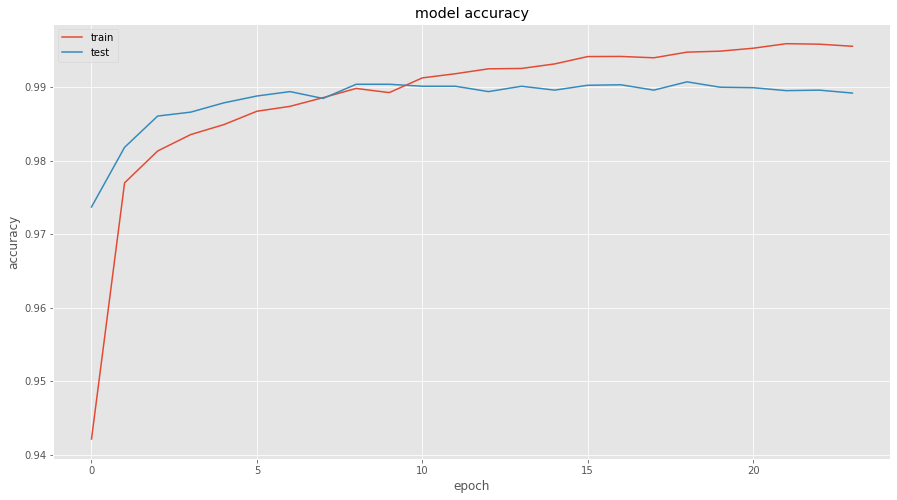

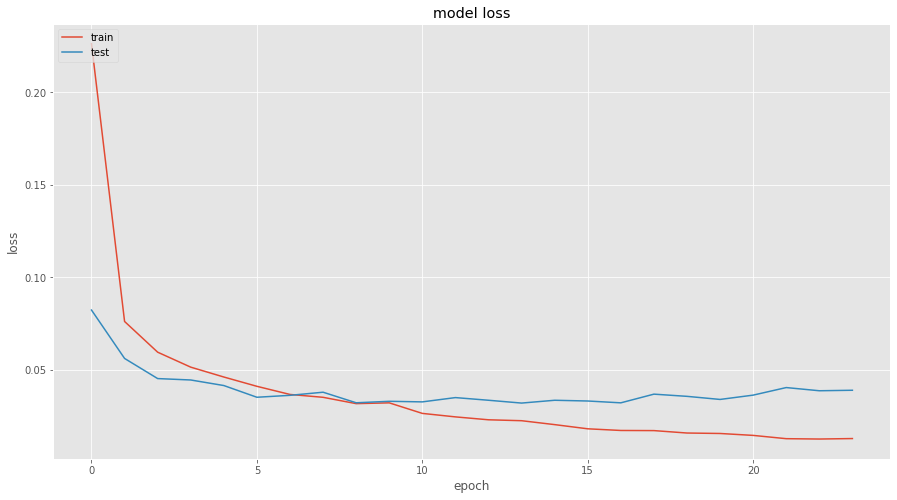

In [46]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.figure(figsize=(15, 8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.figure(figsize=(15, 8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Evaluate the model

In [31]:
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report

In [47]:
test_pred = model.predict(X_test, verbose=1)

idx2tag = {i: w for w, i in tag2idx.items()}

def pred2label(pred):
    out = []
    for pred_i in pred:        
        out_i = []
        for p in pred_i:               
            p_i = np.argmax(p)                                        
            out_i.append(idx2tag[p_i].replace("PAD", "O"))            
        out.append(out_i)        
    return out

pred_labels = pred2label(test_pred)
test_labels = pred2label(y_test)

print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))
print(classification_report(test_labels, pred_labels))

9/9 [==============================] - 0s 32ms/step
F1-score: 78.3%
              precision    recall  f1-score   support

         loc       0.81      0.78      0.79       371
        time       0.78      0.55      0.64        33

   micro avg       0.80      0.76      0.78       404
   macro avg       0.79      0.66      0.72       404
weighted avg       0.80      0.76      0.78       404



In [48]:
from sklearn_crfsuite import metrics

labels = ['B-loc', 'I-loc', 'B-time', 'I-time']
# group B and I results
sorted_labels = sorted(
    labels,
    key=lambda name: (name[1:], name[0])
)
print(metrics.flat_classification_report(
    test_labels, pred_labels, labels=sorted_labels, digits=4
))

print("F1-score: {:.4%}".format(metrics.flat_f1_score(test_labels, pred_labels, average='weighted', labels=labels)))

              precision    recall  f1-score   support

       B-loc     0.8963    0.8428    0.8687       369
       I-loc     0.9410    0.9474    0.9442       893
      B-time     0.8182    0.5455    0.6545        33
      I-time     0.9130    0.6364    0.7500        33

   micro avg     0.9264    0.9006    0.9133      1328
   macro avg     0.8921    0.7430    0.8044      1328
weighted avg     0.9249    0.9006    0.9112      1328

F1-score: 91.1200%


### Evaluando con una muestra

In [36]:
i = 1
p = model.predict(np.array([X_test[i]]))
p = np.argmax(p, axis=-1)
np.argmax(y_test[i], axis=-1)
print("{:15} ({:5}): {}".format("Word", "True", "Pred"))
for w, true, pred in zip(test_sentences[i], np.argmax(y_test[i],axis=-1), p[0]):    
    print("{:15} ({:5}): {}".format(w[0], tags[true], tags[pred]))

Word            (True ): Pred
movilidad       (O    ): O
bogota          (O    ): O
acueducto       (O    ): O
trancon         (O    ): O
accidente       (O    ): O
llevó           (B-time): O
3               (I-time): O
horas           (I-time): O
en              (O    ): O
el              (O    ): O
carro           (O    ): O
bajando         (O    ): O
de              (O    ): O
la              (O    ): O
calera          (B-loc): O
y               (O    ): O
muchos          (O    ): O
Buses           (O    ): O
escolares       (O    ): O
con             (O    ): O
niños           (O    ): O
pequeños        (O    ): O
de              (O    ): O
los             (O    ): O
colegios        (O    ): O
,               (O    ): O
nada            (O    ): O
que             (O    ): O
quitan          (O    ): O
el              (O    ): O
camión          (O    ): O
del             (O    ): O
acueducto       (O    ): O
que             (O    ): O
se              (O    ): O
accidentó       (O    